# Import dependencies

In [1]:
import glob
import os

import numpy as np
from random import shuffle

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as gensim_api

import matplotlib.pyplot as plt

# Load word vectors

In [2]:
word_vectors = gensim_api.load("word2vec-google-news-300")  # 300-dimensional vectors

In [3]:
def preprocess_data(filepath_):
    positive_path_ = os.path.join(filepath_, 'pos')
    negative_path_ = os.path.join(filepath_, 'neg')
    pos_label_ = 1
    neg_label_ = 0
    dataset_ = []

    for filename_ in glob.glob(os.path.join(positive_path_, '*.txt')):
        try:
            with open(filename_, 'r') as f_:
                dataset_.append((pos_label_, f_.read()))
        except UnicodeDecodeError:
            pass

    for filename_ in glob.glob(os.path.join(negative_path_, '*.txt')):
        try:
            with open(filename_, 'r') as f_:
                dataset_.append((neg_label_, f_.read()))
        except UnicodeDecodeError:
            pass

    shuffle(dataset_)
    return dataset_

In [4]:
def tokenize_and_vectorize(dataset_):
    tokenizer_ = TreebankWordTokenizer()
    vectorized_data_ = []
    expected_ = []
    for sample_ in dataset_:
        tokens_ = tokenizer_.tokenize(sample_[1])
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(word_vectors[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
        expected_.append(sample_[0])
    return vectorized_data_, expected_

In [5]:
dataset = preprocess_data("../../src/part_6/stanford_sent_analysis_dataset/aclImdb/test")
print('Result of loading a training dataset:')
print(dataset[0], '\n\n')
print('Len dataset:', len(dataset))
print("Because I don't have enough memory: I'll crop the dataset:")
dataset = dataset[:5000]
print('Len new dataset:', len(dataset))

Result of loading a training dataset:
(0, 'This for one has nothing to do with the absolutely fantastic first flick. And of course us Americans just have to remake everything successful into English, because man reading subtitles is SOOOOO Hard isn\'t it! From what I\'ve see in the new trailers with the adorable now pregnant Jessica Alba (well that sure ruins every teenage boys fantasy everywhere doesn\'t it!) It looks EXACTLY the same but probably w/double the budget. I thought the original was one of the best horror/suspense/mystery flicks I have seen in any language in quite a long while. I would recommend watching that one and skipping this one all together, there is no reason to watch this as there is no reason this even called "The Eye 2" except to capitalize on the excellence that was the first flick. Do yourself a favor watch "The Eye" with the volume turned up and get ready for some probable jumping. I watched it w/headphones on and was pleasantly surprised on the excellence t

In [6]:
vectorized_data, expected = tokenize_and_vectorize(dataset)
del dataset

split_point = int(len(vectorized_data) * .8)
x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

In [7]:
del vectorized_data
del expected
del word_vectors

In [8]:
print("Count train samples:", len(x_train))
print("Count test samples:", len(x_test))

Count train samples: 4000
Count test samples: 1000


In [9]:
# CNN parameters:
maxlen = 400
batch_size = 32         # how many samples to show the net before
#                         backpropagation the error and updating the weights
embedding_dims = 300    # Length of the token vectors to create for passing into the convnet
filters = 250           # Number of filters for train
kernel_size = 3         # The width of the filters (filter matrix = embedding_dims x kernel_size
hidden_dims = 250       # Number of neurons in the plain feedforward net at the end of the chain
epochs = 10             # Number of times for passing the entire training dataset through the net

In [10]:
# 'keras' has a preprocessing helper method, 'pad_sequences', that in theory could be used to pad
# your input data, but it works only with sequences of scalars, not sequences of vectors.
# So let's create own method for padding sequences of vectors:
def pad_trunc(data_, maxlen_):
    new_data_ = []
    zero_vector_ = [0.0 for _ in range(len(data_[0][0]))]
    for sample_ in data_:
        if len(sample_) > maxlen_:
            temp_ = sample_[:maxlen_]
        elif len(sample_) < maxlen_:
            temp_ = sample_
            additional_elems_ = maxlen_ - len(sample_)
            for _ in range(additional_elems_):
                temp_.append(zero_vector_)
        else:
            temp_ = sample_
        new_data_.append(temp_)
    return new_data_

In [11]:
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)
x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)
x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

In [13]:
model = Sequential()

model.add(Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(maxlen, embedding_dims)
))

# GlobalMaxPooping1D applies pooling to all feature map, not to a specific window
model.add(GlobalMaxPooling1D())

model.add(Dense(units=hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation(activation='relu'))

model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

D:\documents\python_projects\natural_language_processing\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 398, 250)       │       225,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 250)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,251 (1.10 MB)

 Trainable params: 288,251 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.6071 - loss: 0.6462 - val_accuracy: 0.8310 - val_loss: 0.3641
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8769 - loss: 0.3014 - val_accuracy: 0.8530 - val_loss: 0.3179
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9637 - loss: 0.1399 - val_accuracy: 0.8620 - val_loss: 0.3014
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9950 - loss: 0.0420 - val_accuracy: 0.8740 - val_loss: 0.2930
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.8750 - val_loss: 0.3112
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8760 - val_loss: 0.3303
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8740 - val_loss: 0.3422
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accu

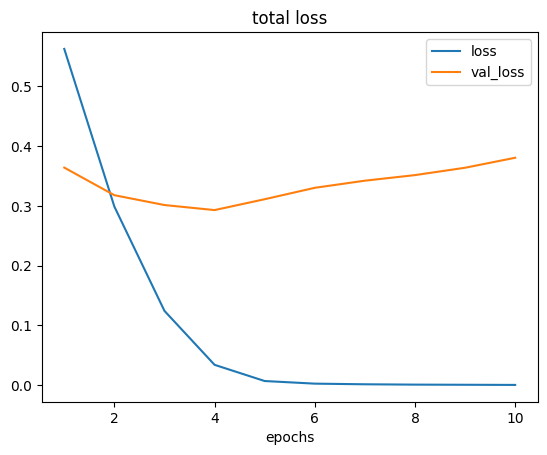

In [16]:
epoch_array = range(1, len(history.history['loss']) + 1)
train_array_hist = history.history['loss']
test_array_hist = history.history['val_loss']

plt.plot(epoch_array, train_array_hist, label="loss")
plt.plot(epoch_array, test_array_hist, label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

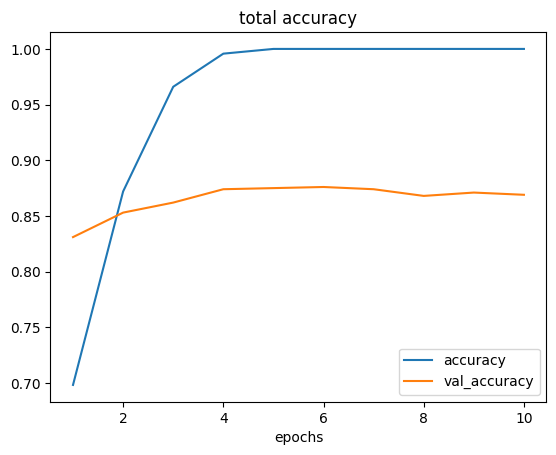

In [18]:
epoch_array = range(1, len(history.history['loss']) + 1)
train_array_hist = history.history['accuracy']
test_array_hist = history.history['val_accuracy']

plt.plot(epoch_array, train_array_hist, label="accuracy")
plt.plot(epoch_array, test_array_hist, label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [20]:
# save model to file:
model_structure = model.to_json()
with open('resulting_models/CONV_sentimal/cnn_model.json', 'w') as json_file:
    json_file.write(model_structure)
model.save_weights('resulting_models/CONV_sentimal/cnn_weights.weights.h5')